In [ ]:
#%% Import libraries

import os
import deeptrack as dt
import torch
import torch.nn as nn
import deeplay as dl
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal

c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\deeptrack\__init__.py:14: UserWarning: TensorFlow is detected in your environment. DeepTrack2 version 2.0++ no longer supports TensorFlow. If you need TensorFlow support, please install the legacy version 1.7 of DeepTrack2:

    pip install deeptrack==1.7

For more details, refer to the DeepTrack documentation.
  warnings.warn(


In [ ]:
#%%load and create data

def plot_image(title, image):
    """Plot a grayscale image with a title."""
    plt.imshow(image, cmap="gray")
    plt.title(title, fontsize=30)
    plt.axis("off")
    plt.show()
    
particle = dt.Sphere(
    position=np.array([0.5, 0.5]) * 64, position_unit="pixel",
    radius=500 * dt.units.nm, refractive_index=1.45 + 0.02j,
)
brightfield_microscope = dt.Brightfield(
    wavelength=500 * dt.units.nm, NA=1.0, resolution=1 * dt.units.um,
    magnification=10, refractive_index_medium=1.33, upsample=2,
    output_region=(0, 0, 64, 64),
)
noise = dt.Poisson(snr=lambda: 5 + np.random.rand())

diverse_particle = dt.Sphere(
    position=lambda: np.array([32, 32]),
    radius=lambda: 500 * dt.units.nm * (0.5 + 1.5*np.random.rand()),
    position_unit="pixel",
    refractive_index=1.45 + 0.02j,
)
diverse_illuminated_sample = brightfield_microscope(diverse_particle)
diverse_clean_particle = (diverse_illuminated_sample >> dt.NormalizeMinMax()
                          >> dt.MoveAxis(2, 0)
                          >> dt.pytorch.ToTensor(dtype=torch.float))
diverse_noisy_particle = (diverse_illuminated_sample >> noise >> dt.NormalizeMinMax()
                          >> dt.MoveAxis(2, 0)
                          >> dt.pytorch.ToTensor(dtype=torch.float))
diverse_pip = diverse_noisy_particle & diverse_clean_particle

blank = brightfield_microscope(particle ^ 0)

# Now pass it through the same noise and preprocessing pipeline
blank_pip = (
    blank
    >> noise  # Still apply noise so model learns to deal with background noise
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

In [ ]:
#%% Dataset with still particles of changing size

class SimulatedDataset(torch.utils.data.Dataset):
    """Simulated dataset simulating pairs of noisy and clean images."""

    def __init__(self, pip, buffer_size, replace=0):
        """Initialize the dataset."""
        self.pip, self.replace = pip, replace
        self.images = [pip.update().resolve() for _ in range(buffer_size)]

    def __len__(self):
        """Return the size of the image buffer."""
        return len(self.images)

    def __getitem__(self, idx):
        """Retrieve a noisy-clean image pair from the dataset."""
        if np.random.rand() < self.replace:
            self.images[idx] = self.pip.update().resolve()
        image_pair = self.images[idx]
        noisy_image, clean_image = image_pair[0], image_pair[1]
        return noisy_image, clean_image
diverse_dataset = SimulatedDataset(diverse_pip, buffer_size=256, replace=0.1)
diverse_loader = torch.utils.data.DataLoader(diverse_dataset, batch_size=8,
                                             shuffle=True)

In [ ]:
#%% Mixed data

class MixedSimulatedDataset(torch.utils.data.Dataset):
    def __init__(self, pip, buffer_size, blank_pip, blank_ratio=0.1, replace=0.1):
        self.pip, self.blank_pip = pip, blank_pip
        self.blank_ratio = blank_ratio
        self.replace = replace
        self.images = [self._generate_pair() for _ in range(buffer_size)]

    def _generate_pair(self):
        if np.random.rand() < self.blank_ratio:
            blank_image = self.blank_pip.update().resolve()
            return blank_image, blank_image.clone()  # Use same image for both noisy and clean
        else:
            return self.pip.update().resolve()  # This already returns a (noisy, clean) pair

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if np.random.rand() < self.replace:
            self.images[idx] = self._generate_pair()
        return self.images[idx]
mixed_dataset = MixedSimulatedDataset(diverse_pip, buffer_size=256, 
                                      blank_pip=blank_pip, blank_ratio=0.2)
mixed_loader = torch.utils.data.DataLoader(mixed_dataset, batch_size=8, shuffle=True)

In [ ]:
#%% Create the VAE

vae = dl.VariationalAutoEncoder(
    input_size=[64,64],
    latent_dim=2, channels=[16,16],
    reconstruction_loss=torch.nn.BCELoss(reduction="sum"), beta=1,
).create()

In [ ]:
# %% Train and predict

vae_trainer = dl.Trainer(max_epochs=20, accelerator="auto")
vae_trainer.fit(vae, mixed_loader)

c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name                | Type                   | Params | Mode 
-----------------------------------------------------------------------
0 | encoder             | ConvolutionalEncoder2d | 4.8 K  | train
1 | fc_mu               | Linear                 | 8.2 K  | train
2 | fc_var              | Linear                 | 8.2 K  | train
3 | fc_dec              | Linear                 | 12.3 K | train
4 | decoder             | ConvolutionalDecoder2d | 6.9 K  | train
5 | reconstruction_loss | BCELoss                | 0      | train
6 | train_metrics       | MetricCollection       | 0      | train
7 | val_metrics         | MetricCollection       | 0      | train
8 | test_metrics        | MetricCollection       | 0      | train
9 | optimizer           | Adam                   |

Training: |          | 0/? [00:00<?, ?it/s]

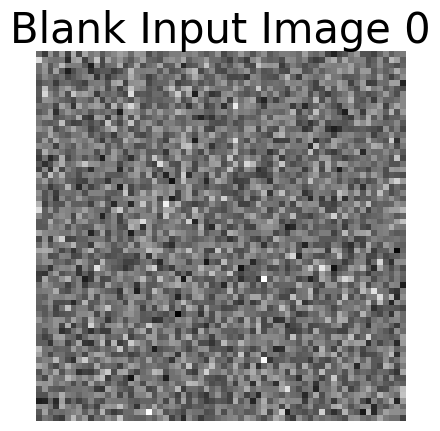

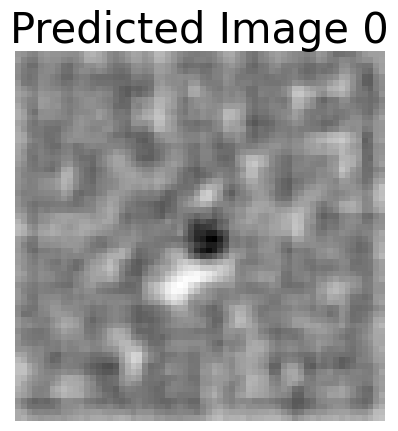

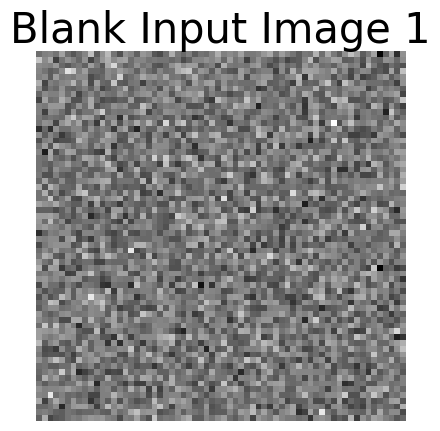

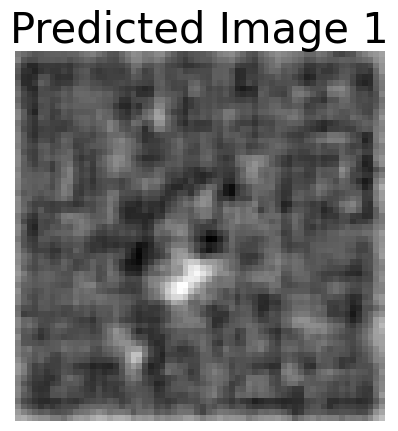

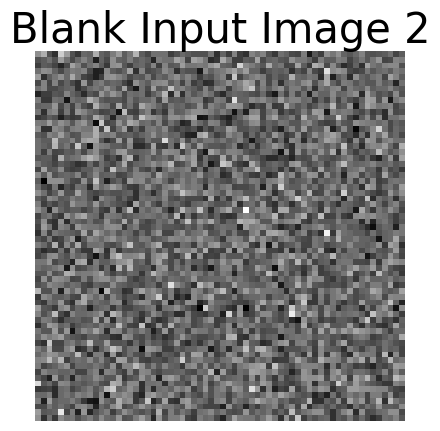

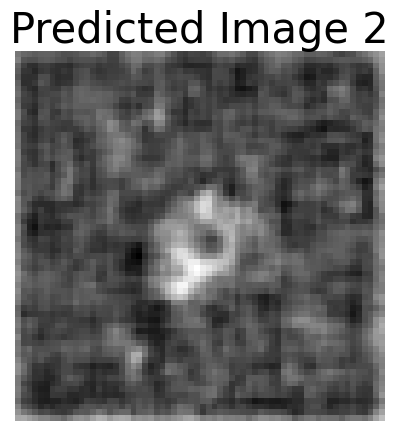

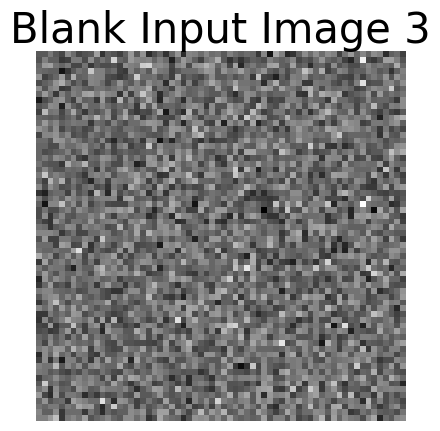

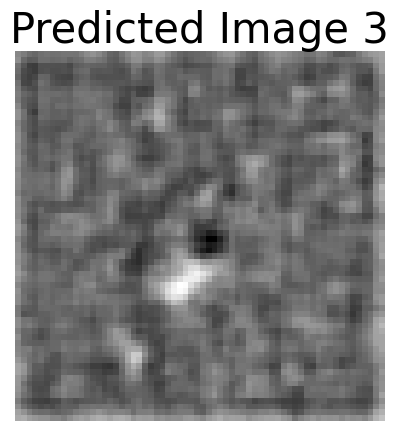

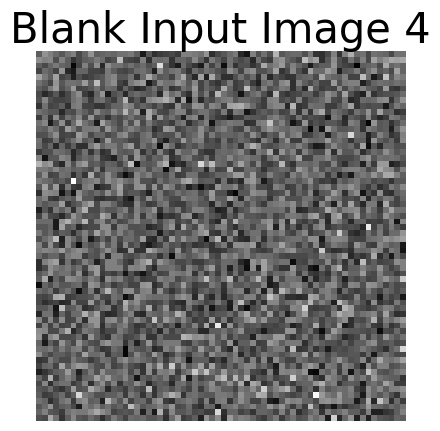

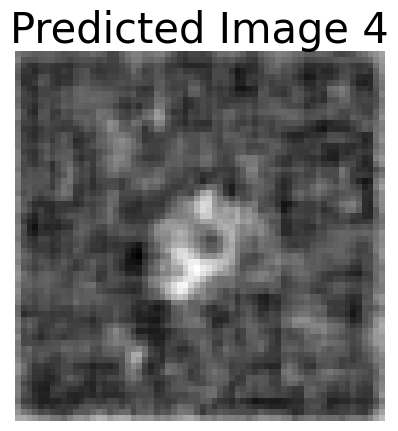

In [ ]:
#%% Mode collapse

blank = brightfield_microscope(particle ^ 0)
blank_pip = (
    blank >> noise >> dt.NormalizeMinMax() >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

for i in range(5):
    blank_image = blank_pip.update().resolve()
    with torch.no_grad():
        blank_predicted = vae(blank_image.unsqueeze(0))[0] 

    plot_image(f"Blank Input Image {i}", blank_image.squeeze().cpu().numpy())
    plot_image(f"Predicted Image {i}", blank_predicted.squeeze().cpu().numpy())

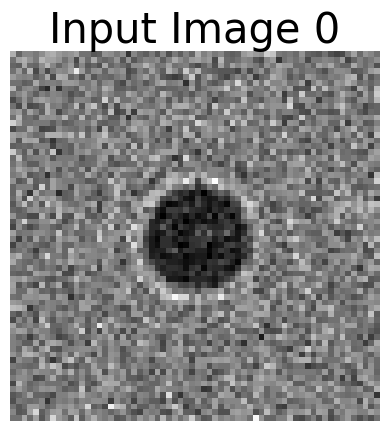

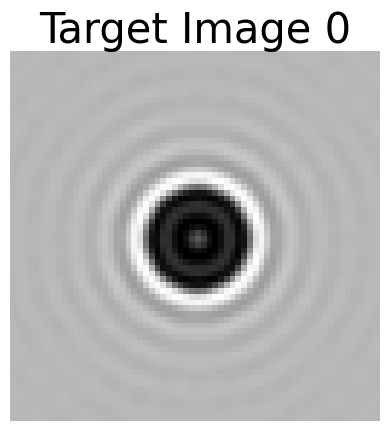

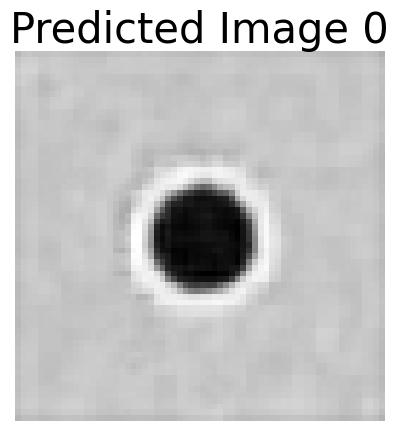

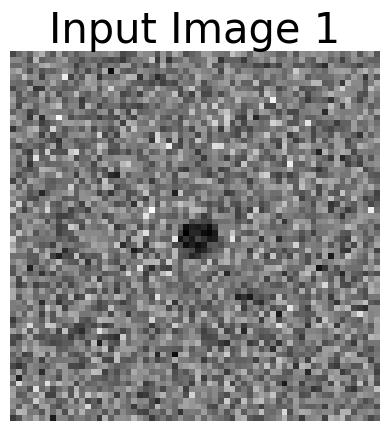

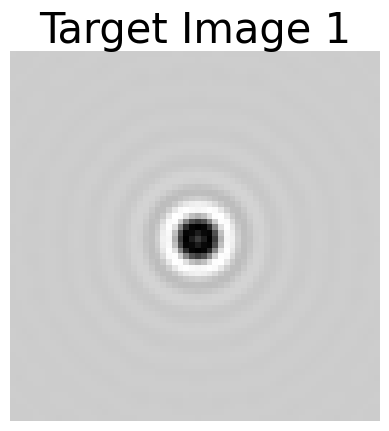

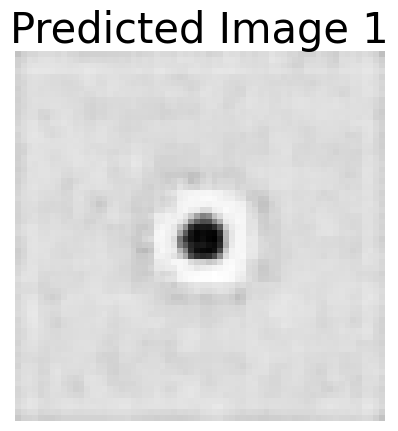

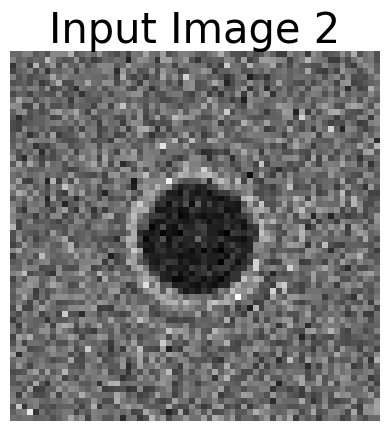

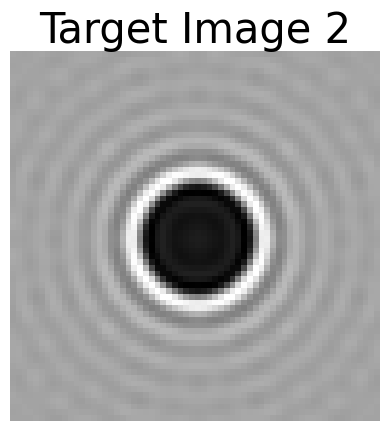

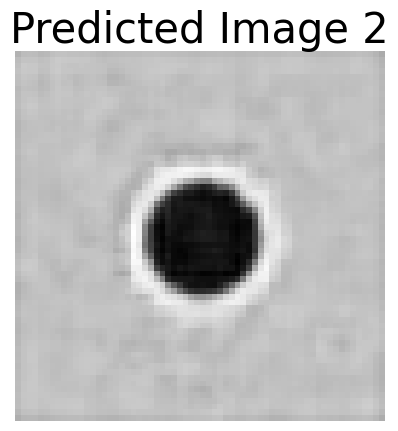

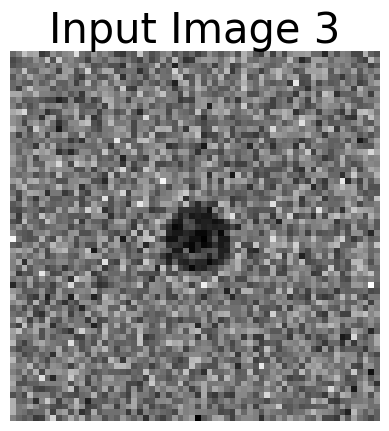

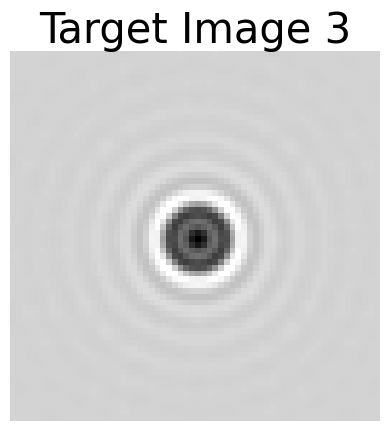

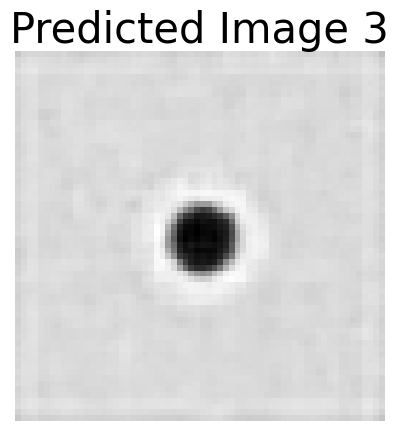

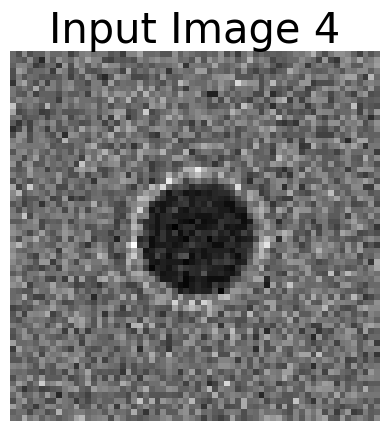

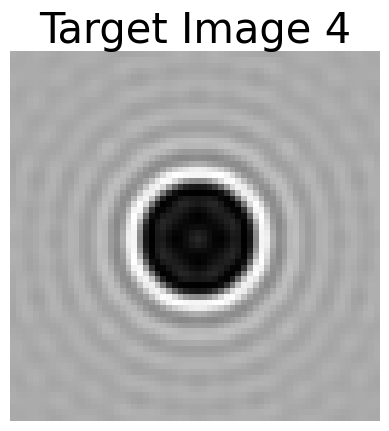

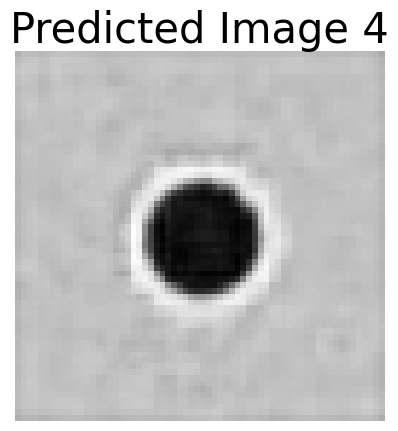

In [ ]:
#%% Predict

for i in range(5):
    input, target = diverse_pip.update().resolve()

    predicted, mu, log_var = vae(input.unsqueeze(0))

    input_img = input.detach().squeeze().cpu().numpy()
    target_img = target.detach().squeeze().cpu().numpy()
    predicted_img = predicted.detach().squeeze().cpu().numpy()

    # Plot each image
    plot_image(f"Input Image {i}", input_img)
    plot_image(f"Target Image {i}", target_img)
    plot_image(f"Predicted Image {i}", predicted_img)

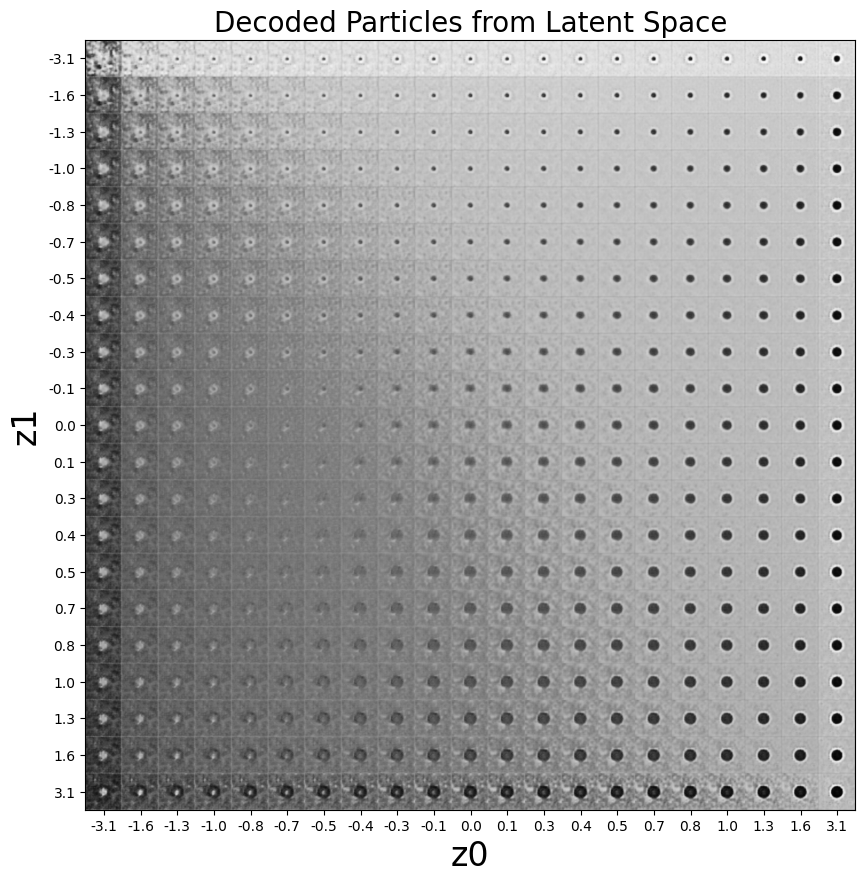

In [ ]:
# %% Generate images

img_num, img_size = 21, 64

z0_grid = z1_grid = Normal(0, 1).icdf(torch.linspace(0.001, 0.999, img_num))

image = np.zeros((img_num * img_size, img_num * img_size))

for i0, z0 in enumerate(z0_grid):
    for i1, z1 in enumerate(z1_grid):
        z = torch.stack((z0, z1)).unsqueeze(0) 
        with torch.no_grad():
            generated_image = vae.decode(z).cpu().squeeze().numpy() 
        image[i1 * img_size : (i1 + 1) * img_size,
              i0 * img_size : (i0 + 1) * img_size] = generated_image

plt.figure(figsize=(10, 10))
plt.imshow(image, cmap="gray")
plt.xlabel("z0", fontsize=24)
plt.xticks(np.arange(0.5 * img_size, (0.5 + img_num) * img_size, img_size),
           np.round(z0_grid.numpy(), 1))
plt.ylabel("z1", fontsize=24)
plt.yticks(np.arange(0.5 * img_size, (0.5 + img_num) * img_size, img_size),
           np.round(z1_grid.numpy(), 1))
plt.title("Decoded Particles from Latent Space", fontsize=20)
plt.show()